In [20]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [21]:
ticker = yf.Ticker("AAPL")
history = ticker.history(period="max")
latest_date = history.tail(1).index[0]
s_date = input("Enter the period in '%Y-%m-%d' format")

In [22]:
BTC_USD = yf.download("BTC-USD", start= s_date, end= latest_date, interval='1d')
BTC_USD.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-01,43194.503906,44793.601562,42952.585938,44354.636719,44354.636719,32479047645
2022-03-02,44357.617188,45077.578125,43432.851562,43924.117188,43924.117188,29183112630
2022-03-03,43925.195312,44021.578125,41914.750000,42451.789062,42451.789062,24967782593
2022-03-04,42458.140625,42479.613281,38805.847656,39137.605469,39137.605469,28516271427
2022-03-05,39148.449219,39566.335938,38777.035156,39400.585938,39400.585938,16975917450


# 1. Computing the Simple Moving Averages (SMA)
Simple Moving Average (SMA) is a popular technical analysis tool used in financial markets to analyze and identify trends in price data. It is a type of moving average, which is a calculation that provides a smoothed average of a security's price over a specified time period, and is constantly updated as new data becomes available.

The SMA is calculated by taking the sum of a specified number of prices over a given time period, and then dividing that sum by the number of prices used in the calculation. For example, a 20-day SMA would be the sum of the last 20 closing prices divided by 20. The resulting value represents the average price of the security over that time period, and it is plotted on a chart to identify trends, support and resistance levels, and potential buy or sell signals.

SMA is called "simple" because it assigns equal weight to all prices in the calculation, treating each price point as equally important. It is commonly used in various trading strategies and technical analysis methods, such as trend-following strategies, moving average crossovers, and support/resistance analysis. SMA is easy to understand and widely used by traders and investors to analyze price data and make informed trading decisions.

In [23]:
BTC_USD['SMA_30'] = BTC_USD['Close'].rolling(window=30, min_periods=1).mean()
BTC_USD['SMA_300'] = BTC_USD['Close'].rolling(window = 300, min_periods = 1).mean()
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_30,SMA_300
Date,,,,,,,,
2023-04-06,28175.226562,28178.384766,27738.759766,28044.140625,28044.140625,13837809380,26283.053971,20918.069557
2023-04-07,28038.966797,28111.593750,27794.031250,27925.859375,27925.859375,10861680497,26489.979948,20916.619720
2023-04-08,27920.513672,28159.863281,27883.386719,27947.794922,27947.794922,9373255556,26742.805729,20920.570208
2023-04-09,27952.367188,28532.830078,27828.480469,28333.050781,28333.050781,12175322951,27014.332617,20940.055749
2023-04-10,28336.027344,29771.464844,28189.271484,29652.980469,29652.980469,19282400094,27315.018294,20964.876374


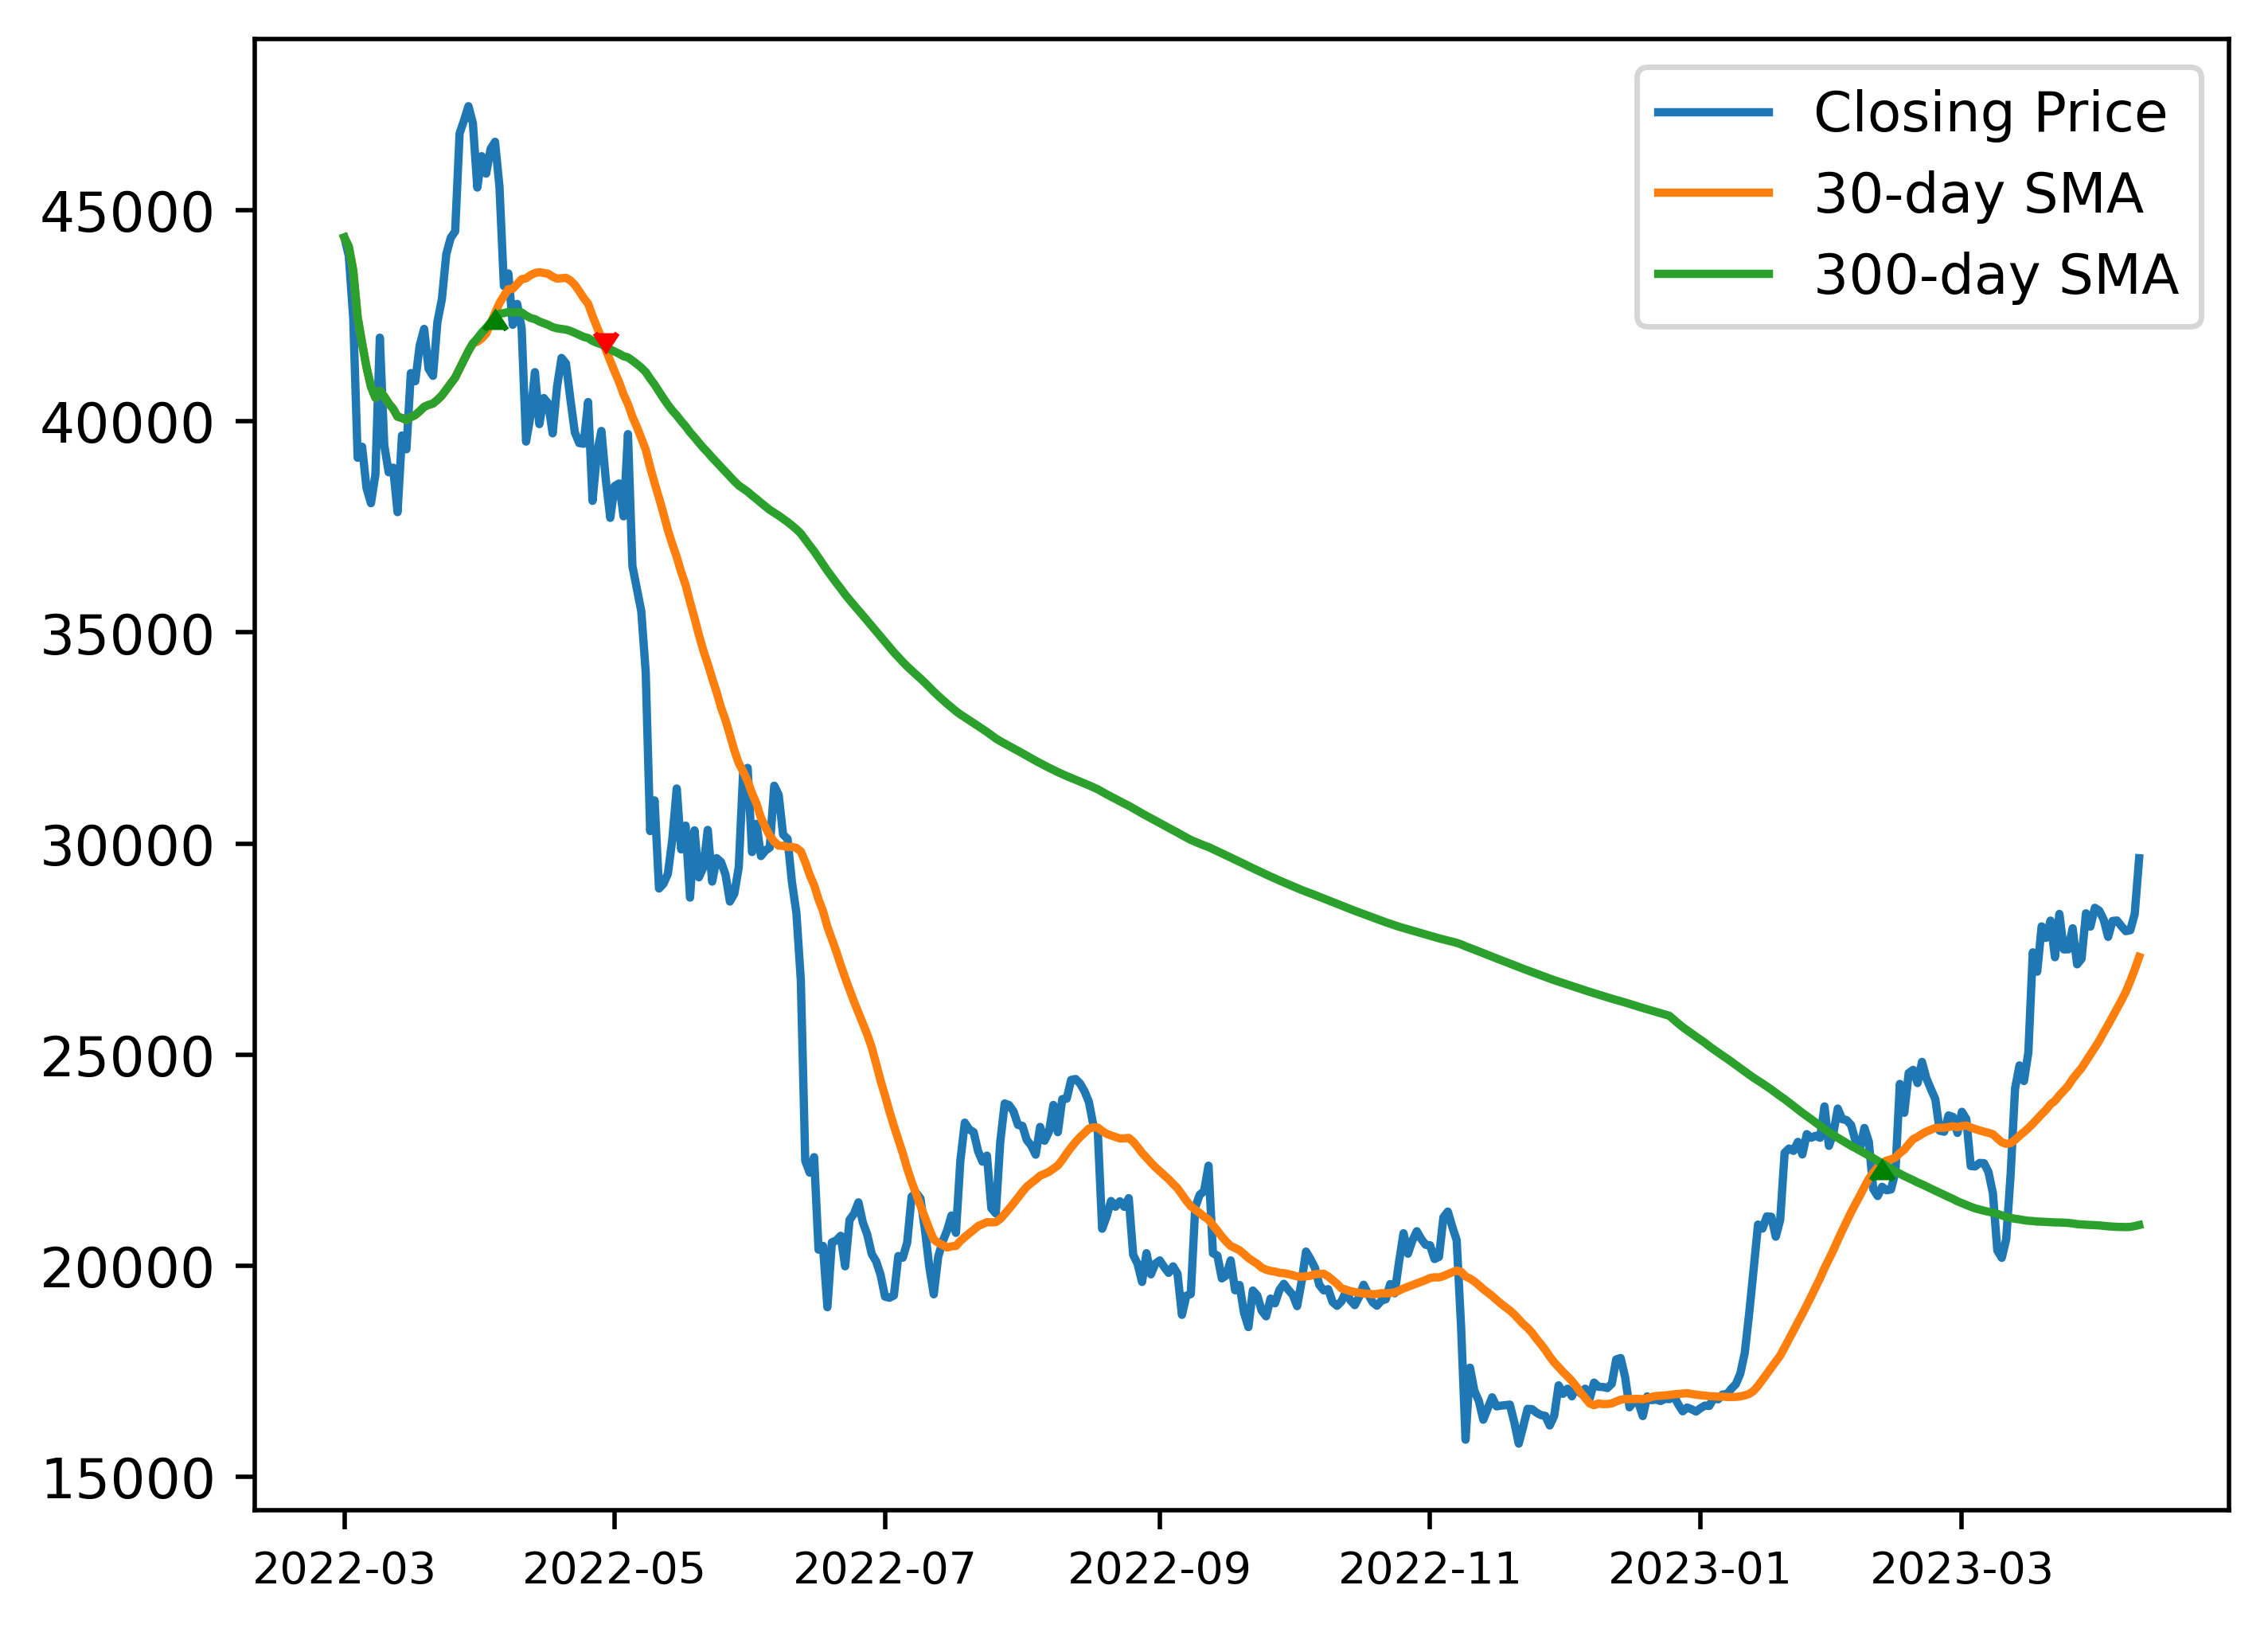

In [24]:
BTC_USD['Signal'] = 0.0
BTC_USD['Signal'] = np.where(BTC_USD['SMA_30'] > BTC_USD['SMA_300'], 1.0, 0.0)   
BTC_USD['Position'] = BTC_USD['Signal'].diff()


fig, ax = plt.subplots(dpi=500)
ax.tick_params(axis='x', labelsize=8)

ax.plot(BTC_USD.index, BTC_USD['Close'], label='Closing Price')
ax.plot(BTC_USD['SMA_30'].index, BTC_USD['SMA_30'] , label='30-day SMA')
ax.plot(BTC_USD['SMA_300'].index, BTC_USD['SMA_300'] , label='300-day SMA')

ax.plot(BTC_USD.loc[BTC_USD['Position']==1.0].index, BTC_USD.SMA_30[BTC_USD['Position'] == 1.0],marker=6, ms=4, linestyle='none', color='green')

 # Adding red arrows to indicate sell orders
ax.plot(BTC_USD.loc[BTC_USD['Position'] == -1.0].index, BTC_USD.SMA_30[BTC_USD['Position'] == -1.0],
 marker=7, ms=4, linestyle='none', color='red')

ax.legend()
plt.show()

# 2. Computing the Relative Strength Index (RSI)
RSI stands for Relative Strength Index, which is a popular technical indicator used in financial markets to measure the strength of price changes and identify potential overbought or oversold conditions. RSI is commonly used in technical analysis to help traders and investors make decisions on buying or selling securities, such as stocks, forex, or commodities.

RSI is calculated based on the magnitude of recent price gains and losses over a specified time period, typically 14 periods, using the following formula:

RSI = 100 - (100 / (1 + RS))

where:

RS (Relative Strength) is the average gain divided by the average loss over the specified time period. It is calculated as:
RS = (Average Gain / Average Loss)

Average Gain is the average of gains (positive price changes) over the specified time period.

Average Loss is the average of losses (negative price changes) over the specified time period.

RSI values range from 0 to 100. A higher RSI value indicates stronger upward momentum in prices, potentially signaling an overbought condition where prices may be due for a pullback. Conversely, a lower RSI value indicates stronger downward momentum in prices, potentially signaling an oversold condition where prices may be due for a rebound.

Traders and investors use RSI to help identify potential trend reversals, confirm price trends, and generate buy or sell signals. For example, a common strategy is to look for RSI values above 70 as a potential overbought condition where prices may be due for a pullback or sell signal, and RSI values below 30 as a potential oversold condition where prices may be due for a rebound or buy signal. However, it's important to use RSI in conjunction with other technical and fundamental analysis tools for a more comprehensive assessment of market conditions.

In [25]:
# Calculate the price change and gain/loss for each day
BTC_USD['PriceChange'] = BTC_USD['Close'] - BTC_USD['Close'].shift(1)
BTC_USD['Gain'] = BTC_USD['PriceChange'].where(BTC_USD['PriceChange'] > 0, 0)
BTC_USD['Loss'] = -BTC_USD['PriceChange'].where(BTC_USD['PriceChange'] < 0, 0)

# Calculate the smoothed average gain and loss
window = 14  # RSI period
BTC_USD['AvgGain'] = BTC_USD['Gain'].rolling(window=window).mean()
BTC_USD['AvgLoss'] = BTC_USD['Loss'].rolling(window=window).mean()

# Calculate the relative strength (RS)
BTC_USD['RS'] = BTC_USD['AvgGain'] / BTC_USD['AvgLoss']

# Calculate the RSI
BTC_USD['RSI'] = 100 - (100 / (1 + BTC_USD['RS']))

# Drop unnecessary columns
BTC_USD = BTC_USD.drop(['PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS'], axis=1)

# Print the DataFrame with RSI values
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_30,SMA_300,Signal,Position,RSI
Date,,,,,,,,,,,
2023-04-06,28175.226562,28178.384766,27738.759766,28044.140625,28044.140625,13837809380,26283.053971,20918.069557,1.0,0.0,47.303586
2023-04-07,28038.966797,28111.593750,27794.031250,27925.859375,27925.859375,10861680497,26489.979948,20916.619720,1.0,0.0,54.649344
2023-04-08,27920.513672,28159.863281,27883.386719,27947.794922,27947.794922,9373255556,26742.805729,20920.570208,1.0,0.0,54.848446
2023-04-09,27952.367188,28532.830078,27828.480469,28333.050781,28333.050781,12175322951,27014.332617,20940.055749,1.0,0.0,53.715559
2023-04-10,28336.027344,29771.464844,28189.271484,29652.980469,29652.980469,19282400094,27315.018294,20964.876374,1.0,0.0,75.012723


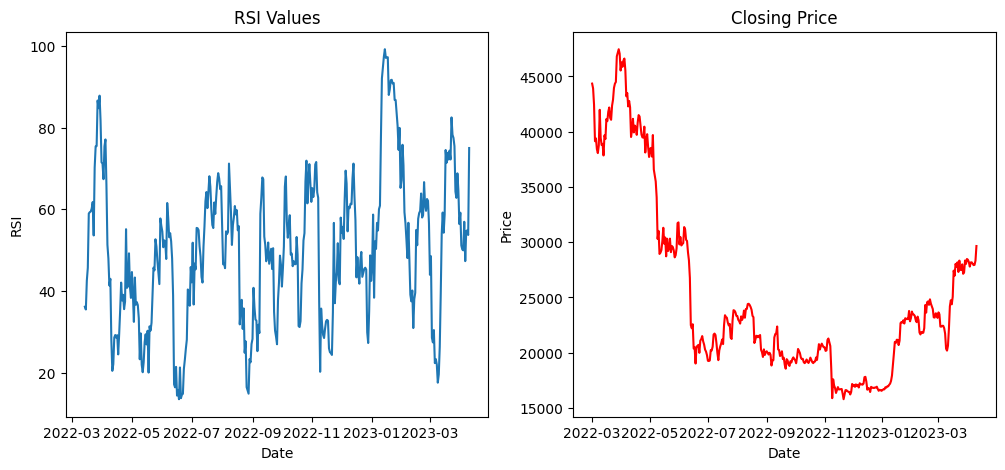

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(BTC_USD['RSI'])
ax1.set_title('RSI Values')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')

ax2.plot(BTC_USD['Close'], c = 'Red')
ax2.set_title('Closing Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')

plt.show()

# 3. Calculating Bollinger Bands
Bollinger Bands are a popular technical analysis tool used in finance to study the volatility and potential price movements of a financial security, such as stocks, forex pairs, or commodities. They consist of three lines plotted on a price chart:

Middle Band (MB): This is typically a simple moving average (SMA) of the security's price over a specified time period (e.g., 20 days). It serves as the centerline of the Bollinger Bands and represents the average price of the security during that period.

Upper Band (UB): This is calculated as a certain number of standard deviations (usually 2) above the middle band. It represents the upper boundary of the expected price range and is often interpreted as a level of resistance.

Lower Band (LB): This is calculated as the same number of standard deviations (usually 2) below the middle band. It represents the lower boundary of the expected price range and is often interpreted as a level of support.

The distance between the upper and lower bands is related to the volatility of the security. When the price moves outside the bands, it may signal potential price reversals or trend changes. Bollinger Bands are often used by traders to identify potential buying or selling opportunities, as well as to manage risk and set stop-loss levels.

Bollinger Bands can be plotted on price charts using various charting tools and software, such as financial analysis platforms, charting software, or programming libraries like matplotlib in Python. They are widely used by technical analysts and traders to assess price volatility, potential breakouts, and trend reversals in financial markets.

In [27]:
BTC_USD['Middle Band'] = BTC_USD['Close'].rolling(window=100).mean()
BTC_USD['Standard Deviation'] = BTC_USD['Close'].rolling(window=100).std()
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_30,SMA_300,Signal,Position,RSI,Middle Band,Standard Deviation
Date,,,,,,,,,,,,,
2023-04-06,28175.226562,28178.384766,27738.759766,28044.140625,28044.140625,13837809380,26283.053971,20918.069557,1.0,0.0,47.303586,22940.590430,3442.496237
2023-04-07,28038.966797,28111.593750,27794.031250,27925.859375,27925.859375,10861680497,26489.979948,20916.619720,1.0,0.0,54.649344,23054.323301,3417.098817
2023-04-08,27920.513672,28159.863281,27883.386719,27947.794922,27947.794922,9373255556,26742.805729,20920.570208,1.0,0.0,54.848446,23167.377832,3389.726447
2023-04-09,27952.367188,28532.830078,27828.480469,28333.050781,28333.050781,12175322951,27014.332617,20940.055749,1.0,0.0,53.715559,23284.682480,3363.118351
2023-04-10,28336.027344,29771.464844,28189.271484,29652.980469,29652.980469,19282400094,27315.018294,20964.876374,1.0,0.0,75.012723,23415.737324,3353.264565


In [28]:
k =2
BTC_USD['Upper Band'] = BTC_USD['Middle Band'] + (k * BTC_USD['Standard Deviation'])
BTC_USD['Lower Band'] = BTC_USD['Middle Band'] - (k * BTC_USD['Standard Deviation'])

BTC_USD = BTC_USD.drop(['Standard Deviation'], axis=1)

BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_30,SMA_300,Signal,Position,RSI,Middle Band,Upper Band,Lower Band
Date,,,,,,,,,,,,,,
2023-04-06,28175.226562,28178.384766,27738.759766,28044.140625,28044.140625,13837809380,26283.053971,20918.069557,1.0,0.0,47.303586,22940.590430,29825.582905,16055.597955
2023-04-07,28038.966797,28111.593750,27794.031250,27925.859375,27925.859375,10861680497,26489.979948,20916.619720,1.0,0.0,54.649344,23054.323301,29888.520934,16220.125668
2023-04-08,27920.513672,28159.863281,27883.386719,27947.794922,27947.794922,9373255556,26742.805729,20920.570208,1.0,0.0,54.848446,23167.377832,29946.830725,16387.924939
2023-04-09,27952.367188,28532.830078,27828.480469,28333.050781,28333.050781,12175322951,27014.332617,20940.055749,1.0,0.0,53.715559,23284.682480,30010.919183,16558.445778
2023-04-10,28336.027344,29771.464844,28189.271484,29652.980469,29652.980469,19282400094,27315.018294,20964.876374,1.0,0.0,75.012723,23415.737324,30122.266454,16709.208195


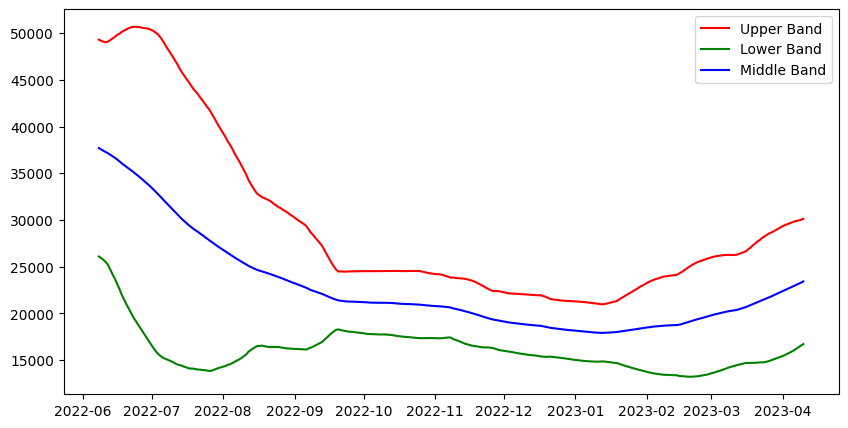

In [32]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(BTC_USD['Upper Band'], label='Upper Band', c ='Red')
ax.plot(BTC_USD['Lower Band'], label='Lower Band', c = 'Green')
ax.plot(BTC_USD['Middle Band'], label='Middle Band', c ='Blue')

ax.legend()


plt.show()